<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Google_CoLab_RNN_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence Models**

### Importing Libraries

In [1]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 57kB/s 
     |████████████████████████████████| 501kB 50.9MB/s 
     |████████████████████████████████| 3.1MB 44.1MB/s 


In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, GaussianNoise, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
tf.__version__

'2.0.0-beta1'

## Autoregressive Model

### Synthetic Data

In [0]:
# synthetic data
series = np.sin (0.1*np.arange(200))

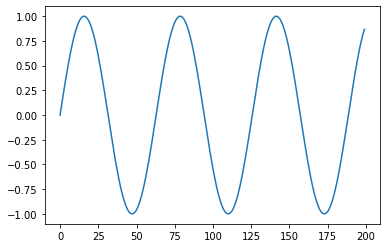

In [11]:
plt.plot(series)
plt.show()

In [0]:
shape = series.shape

### Build a Generator

In [0]:
def gen (series, size=10) :
  i = np.random.randint (size + 1, len(series)+1)
  x = series [i - size - 1 : i-1]
  y = series [i]
  return x, y

In [43]:
gen (series)

(array([0.98935825, 0.96988981, 0.94073056, 0.90217183, 0.85459891,
        0.79848711, 0.7343971 , 0.66296923, 0.58491719, 0.50102086]),
 0.3190983623493521)

### Model Building

In [0]:
i = Input (shape=(10,))

In [0]:
x = Dense (8, activation='relu')(i)
x = Dense (8, activation='relu')(x)
x = Dropout (0.5) (x)
x = Dense (1, activation='relu')(x)

In [0]:
sequence = Model (i, x)

In [0]:
sequence.compile (optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [0]:
epochs = 10